In [23]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax
import scipy.stats
from scipy.special import expit, logit

import imprint as ip
import confirm.adagrid as ada


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#grid = ip.cartesian_grid(
#        [-3, -3], [3, 3], n=[10, 10], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    # )
#lam = 0.025
#x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
#grid.df["null_truth2"] = x
#type(grid.df)
#plt.scatter(grid.df["theta0"], grid.df["theta1"], c = grid.df["null_truth2"])

In [4]:
#First building a function which operates on a single grid point
def closed_test(pvalues, alpha):
    rejected = [False]*len(pvalues)
    for i in range(len(pvalues)):
        curr_rejections = sum(rejected)
        curr_thresh = alpha/(len(pvalues)-sum(rejected))
        rejected = [rejected[i] or pvalues[i] <= curr_thresh for i in range(len(pvalues))]
        if sum(rejected) == len(pvalues):
            break
    return  rejected

In [5]:
#Next, we simultaneously operate on all of the grid-points, and return a list of rejections
def closed_test_half(pvalues, alpha):
    #initialize rejections to false, with shape = shape(pvalues)
    rejected = np.full_like(pvalues, False)
    for i in range(pvalues.shape[1]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(pvalues.shape[1]-sumrejections)
        rejected = rejected or pvalues <= curr_thresh[:,None]
        print(rejected)
    return  rejected

In [6]:
def closed_test_full(pvalues, alpha):
    #initialize rejections to false,
    #will have shape = (#criticalvalues, #hypotheses, #gridpoints, #sims)
    temp = pvalues[None,:,:,:]+alpha[:,None,:,:]
    #temp.shape is (10, 3, 360, 100)
    rejected = np.full_like(temp, False) 
    # alpha.shape is 10, 360, 100
    epsilon = 1e-10
    for i in range(pvalues.shape[0]):
        sumrejections = np.sum(rejected,axis=1)
        curr_thresh = alpha/(epsilon+pvalues.shape[0]-sumrejections)
        rejected = np.less_equal(pvalues[None,:,:,:], curr_thresh[:,None,:,:])
    return  rejected

In [7]:
class BinomialClosed:
    def __init__(self, seed, max_K, *, n):
        self.family = "binomial"
        self.family_params = {"n": n[0]}
        self.n=n
        key = jax.random.PRNGKey(seed)
        splitkeys = jax.random.split(key, num=2)
        self.samples_arm1 = jax.random.uniform(
            splitkeys[1], shape=(max_K, n[1]), dtype=np.float32
        )
        
        self.samples_arm0 = jax.random.uniform(
            splitkeys[0], shape=(max_K, n[0]), dtype=np.float32
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        p = expit(theta)
        # successes is a 2-dimensional array of shape: (n_tiles, n_sims = K)
        successes1 = np.sum(self.samples_arm1[None, begin_sim:end_sim, :] < p[:, None, None, 1],axis =2)
        successes0 = np.sum(self.samples_arm0[None, begin_sim:end_sim, :] < p[:, None, None, 0],axis =2)
        phat1 = successes1 / self.n[1]
        phat0 = successes0 / self.n[0]
        #pooledphat = (phat1*self.n[1] + phat0*self.n[0]) / (self.n[1] + self.n[0])
        zstat0 = (phat0 - 0.5) / np.sqrt(phat0 * (1 - phat0) / self.n[0])
        zstat1 = (phat1 - 0.7)/ np.sqrt(phat1 * (1 - phat1) / self.n[1])
        zstatcombo = (0.4 * (phat0 -0.5)+ 0.6* (phat1- 0.7)) / np.sqrt( 0.4**2 * phat0*(1-phat0)/ self.n[0] + 0.6**2 * phat1*(1-phat1)/ self.n[1])
        pvalues = 1-scipy.stats.norm.cdf([zstat0,zstat1,zstatcombo])
        pvalues = np.nan_to_num(pvalues) + ([phat0,phat1,phat1 * phat0] == np.full_like(pvalues,0))
        # The following needs to be vectorized
        possible_critical_values = np.sort(np.concatenate((pvalues,2*pvalues,3*pvalues,np.full_like(pvalues[1,:,:],100)[None,:,:])), axis = 0)
        #next we need to apply closed testing to the 3 pvalues for EVERY choice in the list of possible critical values
        rejections_list = closed_test_full(pvalues, possible_critical_values)
        nullstatus = np.asarray(np.transpose(null_truth))
        falserejs = np.logical_and(rejections_list,nullstatus[None,:,:,None])
        fwer = np.any(falserejs, axis = 1)
        #some akwardness to cause the following minimum to give us the right answer
        temp = 1000*(1 - fwer) + fwer*possible_critical_values
        out = np.min(temp, axis=0)
        #out.shape : n_tiles, n_sims
        return out


In [8]:
grid = ip.cartesian_grid(
    [-0.5, 0],
    [1.5, 2],
    n=[20, 20],
    prune=True,
    null_hypos=[
        ip.hypo("theta0 < " + str(logit(0.5))),
        ip.hypo("theta1 <" + str(logit(0.7))),
    ],
)
x = (
    expit(grid.df["theta0"] - grid.df["radii0"]) * 0.4
    + 0.6 * expit(grid.df["theta1"] - grid.df["radii1"])
    < 0.5 * 0.4 + 0.7 * 0.6
)
grid.df["null_truth2"] = x
x = BinomialClosed(0, 2, n=[100, 100])
outs = x.sim_batch(
    0,
    2,
    theta=grid.get_theta(),
    null_truth=grid.df[["null_truth0", "null_truth1", "null_truth2"]],
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1675691039, n_bits=18, worker_bits=18) = [4472146929027121152 4472146929027121153 4472146929027121154, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1675691040, n_bits=18, worker_bits=18) = [4472146997746597888 4472146997746597889 4472146997746597890, ...]:


KeyError: "['null_truth2'] not in index"

In [ ]:
grid = ip.cartesian_grid(
        [-0.5, 0], [1.5, 2], n=[100, 100], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
    )
x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
grid.df["null_truth2"] = x
type(grid.df)
y = ip.validate(BinomialClosed, grid, lam = 0.025, K=10000, model_kwargs=dict(n=[100,100]))


DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1600, worker_id=1, t=1675692405, n_bits=18, worker_bits=18) = [4472240799832342528 4472240799832342529 4472240799832342530, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=80, worker_id=1, t=1675692406, n_bits=18, worker_bits=18) = [4472240868551819264 4472240868551819265 4472240868551819266, ...]:


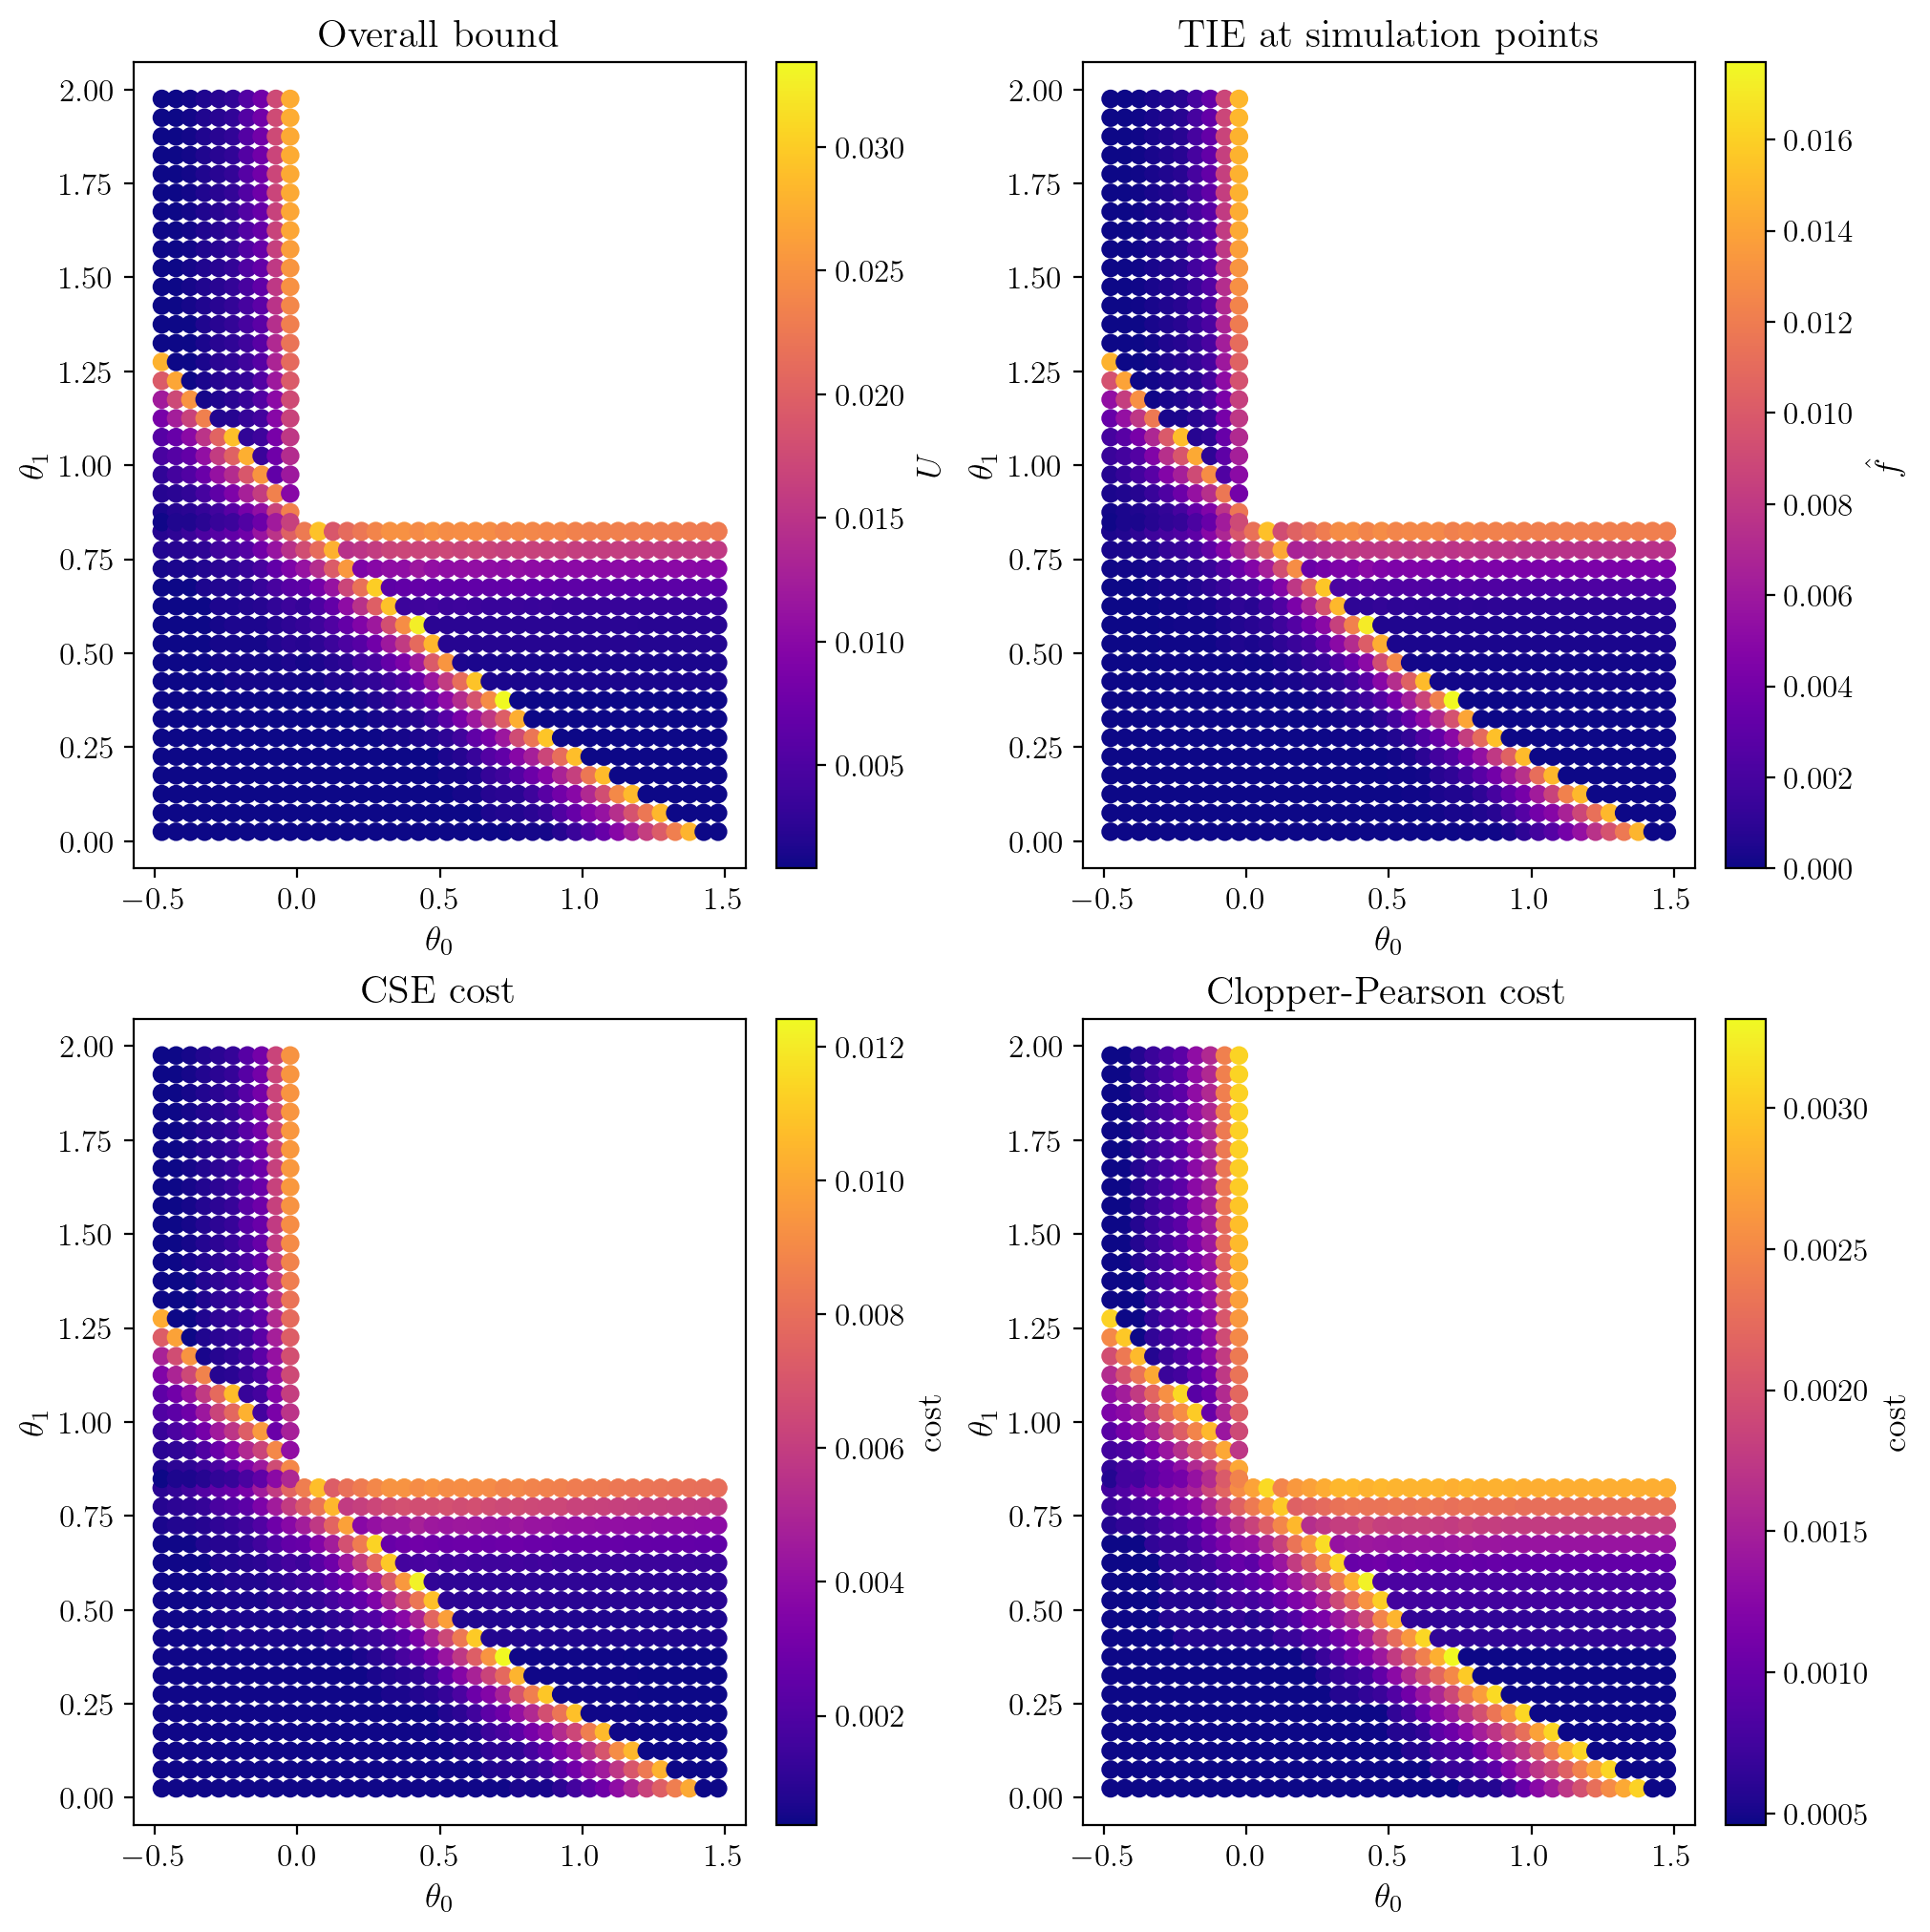

In [32]:
grid = ip.cartesian_grid(
    [-0.5, 0],
    [1.5, 2],
    n=[40, 40],
    prune=True,
    null_hypos=[
        ip.hypo("theta0 < " + str(logit(0.5))),
        ip.hypo("theta1 <" + str(logit(0.7))),
    ],
)
x = (
    expit(grid.df["theta0"] - grid.df["radii0"]) * 0.4
    + 0.6 * expit(grid.df["theta1"] - grid.df["radii1"])
    < 0.5 * 0.4 + 0.7 * 0.6
)
grid.df["null_truth2"] = x
val_df = ip.validate(
    BinomialClosed, g=grid, lam=0.025, K=10000, model_kwargs=dict(n=[100, 100])
)

ada.summarize_validate(grid, val_df)

In [37]:
cal_df = ada.calibrate(BinomialClosed, g=grid, alpha=0.025, K=2000, model_kwargs=dict(n=[100,100]))
plt.hist(cal_df["lams"], bins = 100)
plt.show()

AttributeError: module 'confirm.adagrid' has no attribute 'calibrate'

In [ ]:
cal_df['lams'].min()

0.027130883

In [35]:
cal_df['idx']

0      249
1      249
2      249
3      249
4      249
      ... 
955    249
956    249
957    249
958    249
959    249
Name: idx, Length: 960, dtype: int32

In [36]:
cal_df['alpha0']

0      0.015295
1      0.015281
2      0.015268
3      0.015259
4      0.015251
         ...   
955    0.016201
956    0.016244
957    0.016288
958    0.016332
959    0.016377
Name: alpha0, Length: 960, dtype: float32

[0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.02672807, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.03617606, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883, 0.027130883]


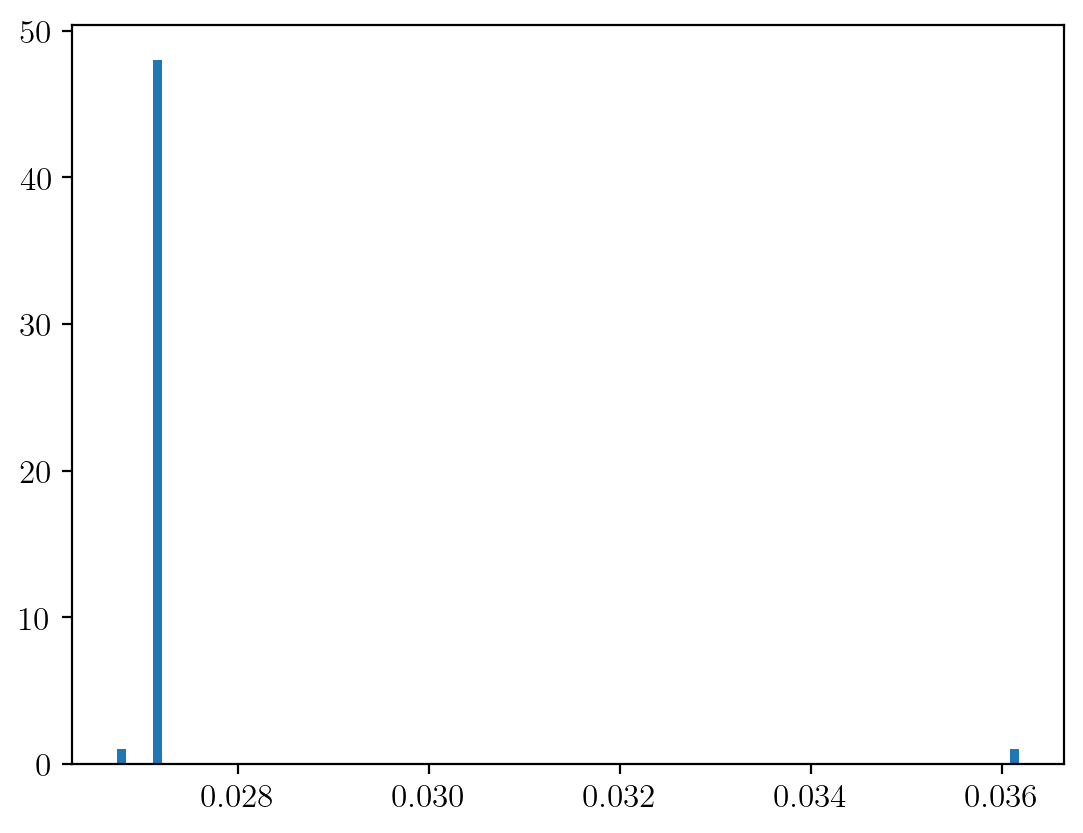

In [ ]:
B_lamss = [cal_df[c].min() for c in cal_df.columns if 'B_lams' in c]
print(B_lamss)
plt.hist(B_lamss, bins = 100)
plt.show()